# Robust training with MOM on PyTorch

In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
import numpy.random as alea
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
from random import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import progressbar
import momAPI.nn.indexed_dataset as indexed_dataset
import momAPI.nn.utilities as utilities
import momAPI.nn.MOM_training as MOM_training
import momAPI.nn.MOM_sampler as MOM_sampler
import momAPI.nn.classical_nn_training as class_train
from math import log

momAPI package
In nn __init__
In procedure __init__
In Cross_validation __init__
In Linear_models __init__


In [2]:
plt.style.use('seaborn-darkgrid')
random_seed = 7
alea.seed(random_seed)

### Test on custom model

Let $U_1,U_2$ be stochastic function, and $Y = \sigma(U_1)\sigma(2U_2)$, we want to predict Y knowing $U_1$ and $U_2$ but there are outliers in the data.

In [207]:
n_obs = 2000
n_outliers = 5

U1 = np.random.normal(0,1,n_obs)
U2 = np.random.normal(0,1,n_obs)

outliers_pos = np.random.randint(0, n_obs, n_outliers)

U = torch.FloatTensor(np.vstack((U1,U2)).transpose())

U1, U2 = torch.FloatTensor(U1), torch.FloatTensor(U2)
Y = torch.sigmoid(U1) * torch.sigmoid(U2)

for i in outliers_pos:
    Y[i] = 1000

data = indexed_dataset.Dataset(U , Y)

In [208]:
class nn(torch.nn.Module):
    
    #Our batch shape for input x is (3 , 64 , 64)
    
    def __init__(self):
        super(nn, self).__init__()

        self.layer = torch.nn.Linear(2, 1)
        
    def forward(self, x):
        x = torch.sigmoid(self.layer(x))
        x = x.view(-1)
        return(x)

In [5]:
nn_ = nn()
optimizer = torch.optim.SGD( nn_.parameters(), lr=0.5)
loss_ = torch.nn.modules.loss.MSELoss()
MOM_nn = MOM_training.mom_net(nn_ , optimizer , loss_ , random_seed = random_seed, n_epochs = 100 , batch_size = 16, n_hist = 100)
MOM_nn.fit(data)

Epoch n°0 ( 0.0 sec) : loss = 0.12081246823072433 Accuracy = None
Epoch n°1 ( 0.0 sec) : loss = 0.11233393102884293 Accuracy = None
Epoch n°2 ( 0.0 sec) : loss = 0.09948112070560455 Accuracy = None
Epoch n°3 ( 0.0 sec) : loss = 0.08895105868577957 Accuracy = None
Epoch n°4 ( 0.0 sec) : loss = 0.08152949064970016 Accuracy = None
Epoch n°5 ( 0.0 sec) : loss = 0.07112830132246017 Accuracy = None
Epoch n°6 ( 0.0 sec) : loss = 0.062196433544158936 Accuracy = None
Epoch n°7 ( 0.0 sec) : loss = 0.05579642206430435 Accuracy = None
Epoch n°8 ( 0.0 sec) : loss = 0.04944530501961708 Accuracy = None
Epoch n°9 ( 0.0 sec) : loss = 0.0456925667822361 Accuracy = None
Epoch n°10 ( 0.0 sec) : loss = 0.041156355291604996 Accuracy = None
Epoch n°11 ( 0.0 sec) : loss = 0.03685937076807022 Accuracy = None
Epoch n°12 ( 0.0 sec) : loss = 0.03318239748477936 Accuracy = None
Epoch n°13 ( 0.0 sec) : loss = 0.029460856691002846 Accuracy = None
Epoch n°14 ( 0.0 sec) : loss = 0.02751944400370121 Accuracy = None
Epo

In [6]:
nnbis_ = nn()
optimizerbis = torch.optim.SGD( nnbis_.parameters(), lr=0.5)
loss_ = torch.nn.modules.loss.MSELoss()
classical_nn = class_train.mom_net(nnbis_ , optimizerbis , loss_ , random_seed = random_seed, n_epochs = 100 , batch_size = 16, n_hist = 100)
classical_nn.fit(data)

Epoch n°0 ( 0.0 sec) : loss = 312012.14290910587 Accuracy = None
Epoch n°1 ( 0.0 sec) : loss = 311937.12240999937 Accuracy = None
Epoch n°2 ( 0.0 sec) : loss = 311936.6813147664 Accuracy = None
Epoch n°3 ( 0.0 sec) : loss = 311936.2099188566 Accuracy = None
Epoch n°4 ( 0.0 sec) : loss = 311935.6940599233 Accuracy = None
Epoch n°5 ( 0.0 sec) : loss = 311935.15044534206 Accuracy = None
Epoch n°6 ( 0.0 sec) : loss = 311934.67129948735 Accuracy = None
Epoch n°7 ( 0.0 sec) : loss = 311934.237252444 Accuracy = None
Epoch n°8 ( 0.0 sec) : loss = 311933.78805214167 Accuracy = None
Epoch n°9 ( 0.0 sec) : loss = 311933.315626055 Accuracy = None
Epoch n°10 ( 0.0 sec) : loss = 311932.84553289413 Accuracy = None
Epoch n°11 ( 0.0 sec) : loss = 311932.37263566256 Accuracy = None
Epoch n°12 ( 0.0 sec) : loss = 311931.88671043515 Accuracy = None
Epoch n°13 ( 0.0 sec) : loss = 311931.4612465203 Accuracy = None
Epoch n°14 ( 0.0 sec) : loss = 311931.0972850323 Accuracy = None
Epoch n°15 ( 0.0 sec) : loss 

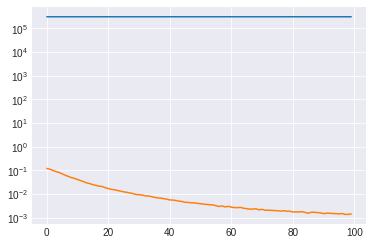

In [7]:
plt.plot(classical_nn.history['loss'])
plt.plot(MOM_nn.history['loss'])
plt.yscale('log')

### The database

We want to classify crocodiles and pionguins extracted from tiny-resnet. In order to check if our training is robust to outliers, we corrupt our dataset with fish photos.

#### Data importation

In [3]:
def rescale(img):
    _,_,channel = img.shape
    tab = np.zeros(img.shape)
    for i in range(channel):
        mini = np.min(img[:,:,i])
        maxi = np.max(img[:,:,i])
        tab[:,:,i] = (img[:,:,i] - mini)/(maxi-mini)
    
    return tab

In [70]:
images = []
target = []
min_n , min_p = 1000 , 1000
i = 0

for animal in ["crocodile" , "pinguin"] : 
    
    file = os.listdir("data/tiny-imagenet-200/train/" + animal + "/images")
    
    for f in file : 
        
        img = Image.open("data/tiny-imagenet-200/train/" + animal + "/images/" + f)
        n,p = img.size
        height = min(n,p)
        box = ( 0 , 0 , height , height)
        img = img.crop(box)  # On rend l'image carré en la rognant
        #img = img.resize(( 224 , 224 ))   # On standardise la taille de l'image 
        if len(np.array(img).shape) == 3 : 
            
            images.append(rescale(np.array(img)))
            target.append([i])
            
    i += 1

outliers_1 = []

file = os.listdir("data/tiny-imagenet-200/train/fish/images")
    
for f in file : 
        
    img = Image.open("data/tiny-imagenet-200/train/fish/images/" + f)
    n,p = img.size
    height = min(n,p)
    box = ( 0 , 0 , height , height)
    img = img.crop(box)
    if len(np.array(img).shape) == 3 : 
            
        outliers_1.append(rescale(np.array(img)))

images_train , images_test , target_train , target_test = train_test_split(images , target ,
                                                                           random_state = random_seed)

#### Creation of the noisy outliers

In [71]:
n_samples = len(target)
sigma = 1
n_outliers_2 = 40
outliers_2 = []
target_outliers_2 = []

indexes = np.random.choice([i for i in range(n_samples)], n_outliers_2)

for i in indexes:
    outliers_2.append(rescale(images[i] + np.random.normal(0, sigma, images[i].shape)))
    target_outliers_2.append(target[i])

#### Creation of the corrupted train set

In [72]:
n_outliers_1 = 0

for i in range(n_outliers_1):
    images_train.append(outliers_1[i])
    target_train.append([randint(0,1)])
    
images_train += outliers_2
target_train += target_outliers_2

target_train = torch.FloatTensor(target_train)
target_test = torch.FloatTensor(target_test)

#### Data transformation

First we create a transformer in order to transform np.array to torch.tensor with the channels in the first dimension.

In [73]:
transformer = transforms.Compose( [ transforms.ToTensor() ])
data_train = indexed_dataset.Dataset(images_train , target_train , transform = transformer)
data_test = indexed_dataset.Dataset(images_test , target_test , transform = transformer)

### The network

For the architecture of my network, I used 3 convolutional layers with Relu activation, each followed by a max pooling layer, in order to extract the best feature. Then I had a dense layer with sigmoid activation in order to do 0/1 classification.

In [74]:
class CNN(torch.nn.Module):
    
    #Our batch shape for input x is (3 , 64 , 64)
    
    def __init__(self):
        super(CNN, self).__init__()
        
        #input channels = 3, output channels = 16
        self.block_1 = torch.nn.Sequential(torch.nn.Conv2d(3 , 32 , 3 , stride = 1 , padding = 0),
                                     torch.nn.BatchNorm2d(32),
                                     torch.nn.ReLU(),
                                     torch.nn.MaxPool2d(3))
        
        #Input channels = 16, output channels = 32
        self.block_2 = torch.nn.Sequential(torch.nn.Conv2d(32 , 64 , 3 , stride = 1 , padding = 0),
                                     torch.nn.BatchNorm2d(64),
                                     torch.nn.ReLU(),
                                     torch.nn.MaxPool2d(2))
        
        #Input channels = 32, output channels = 64
        self.block_3 = torch.nn.Sequential(torch.nn.Conv2d(64 , 128 , 3 , stride = 1 , padding = 0),
                                     torch.nn.BatchNorm2d(128),
                                     torch.nn.ReLU(),
                                     torch.nn.MaxPool2d(2))
        
        #128 input features, 1 output features for binary classification
        self.fc1 = torch.nn.Linear(1152, 1)
        
        #self.conv_dropout = nn.Dropout2d(p = 0.0)
        self.dense_dropout = torch.nn.Dropout(p = 0.0)
        
    def forward(self, x):
        #print("1:", (x == x).all())
        #Computes the Fivation of the first convolution
        #Size changes from (3, 64, 64) to (16, 32, 32)
        x = self.block_1(x)
        #print(x.size())
        #print("1:", (x == x).all())
        
        #Size changes from (16, 32, 32) to (32, 16, 16)
        x = self.block_2(x)
        #print(x.size())
        #print("2:", (x == x).all())
        
        #Size changes from (32, 16, 16) to (64, 6, 6)
        x = self.block_3(x)
        #print(x.size())
        #print("3:", (x == x).all())
        
        #Reshape data to input to the input layer of the neural net
        #Size changes from (128 , 1 , 1) to (1, 128)
        #Recall that the -1 infers this dimension from the other given dimension
        #print(x.size())
        x = x.view(-1,1152)
        
        #Computes the Fivation of the fully connected layer
        #Size changes from (1, 2304) to (1, 1)
        x = torch.sigmoid(self.dense_dropout(self.fc1(x)))
        
        return(x)

### Training

We use Adam optimizer and our loss is the classical binary cross entropy which can be calculated with the following formula : 
$$ BCE(y,\widehat{y}) = -(ylog(\widehat{y})+(1-y)log(1-\widehat{y}))$$

In [75]:
CNN_ = CNN()
optimizer = torch.optim.SGD( CNN_.parameters(), lr=0.01)
loss_ = torch.nn.modules.loss.BCELoss()

In [76]:
MOM_CNN = MOM_training.mom_net(CNN_ , optimizer , loss_ , random_seed = random_seed, n_epochs = 200 , batch_size = 16, n_hist = 50)
MOM_CNN.fit(data_train , data_val = data_test, acc = True)
torch.save(MOM_CNN.model.state_dict(), "models/CNN_1")

Epoch n°0 ( 8.0 sec) : loss = 0.7201804518699646 ,validation loss =  0.6601917743682861 , accuracy : 0.5412960609911055 , validation accuracy : 0.6104417670682731
Epoch n°1 ( 6.0 sec) : loss = 0.6948007345199585 ,validation loss =  0.6385699510574341 , accuracy : 0.5667090216010164 , validation accuracy : 0.6104417670682731
Epoch n°2 ( 5.0 sec) : loss = 0.6629015207290649 ,validation loss =  0.617382287979126 , accuracy : 0.6670902160101652 , validation accuracy : 0.6746987951807228
Epoch n°3 ( 5.0 sec) : loss = 0.6392175555229187 ,validation loss =  0.6073789000511169 , accuracy : 0.7445997458703939 , validation accuracy : 0.7269076305220883
Epoch n°4 ( 5.0 sec) : loss = 0.6064521670341492 ,validation loss =  0.5620909929275513 , accuracy : 0.7191867852604829 , validation accuracy : 0.7831325301204819
Epoch n°5 ( 5.0 sec) : loss = 0.5867539644241333 ,validation loss =  0.550713837146759 , accuracy : 0.7458703939008895 , validation accuracy : 0.7991967871485943
Epoch n°6 ( 6.0 sec) : l

Epoch n°50 ( 6.0 sec) : loss = 0.3379252552986145 ,validation loss =  0.3665623962879181 , accuracy : 0.8983481575603558 , validation accuracy : 0.8353413654618473
Epoch n°51 ( 6.0 sec) : loss = 0.33647871017456055 ,validation loss =  0.4038386940956116 , accuracy : 0.8754764930114358 , validation accuracy : 0.8192771084337349
Epoch n°52 ( 7.0 sec) : loss = 0.40967026352882385 ,validation loss =  0.41703423857688904 , accuracy : 0.8856416772554002 , validation accuracy : 0.8152610441767069
Epoch n°53 ( 6.0 sec) : loss = 0.37549588084220886 ,validation loss =  0.3808932602405548 , accuracy : 0.8818297331639136 , validation accuracy : 0.8433734939759037
Epoch n°54 ( 7.0 sec) : loss = 0.3553132116794586 ,validation loss =  0.36084845662117004 , accuracy : 0.8780177890724269 , validation accuracy : 0.8554216867469879
Epoch n°55 ( 7.0 sec) : loss = 0.3270842730998993 ,validation loss =  0.3338848054409027 , accuracy : 0.8869123252858958 , validation accuracy : 0.8674698795180723
Epoch n°56 

Epoch n°100 ( 5.0 sec) : loss = 0.21921761333942413 ,validation loss =  0.31224459409713745 , accuracy : 0.9174078780177891 , validation accuracy : 0.8554216867469879
Epoch n°101 ( 6.0 sec) : loss = 0.2680535614490509 ,validation loss =  0.3253151476383209 , accuracy : 0.8983481575603558 , validation accuracy : 0.8795180722891567
Epoch n°102 ( 5.0 sec) : loss = 0.2525482773780823 ,validation loss =  0.3045426905155182 , accuracy : 0.9110546378653113 , validation accuracy : 0.8875502008032129
Epoch n°103 ( 5.0 sec) : loss = 0.23396573960781097 ,validation loss =  0.2870699465274811 , accuracy : 0.9085133418043202 , validation accuracy : 0.8995983935742972
Epoch n°104 ( 5.0 sec) : loss = 0.2545444369316101 ,validation loss =  0.2809976637363434 , accuracy : 0.9161372299872935 , validation accuracy : 0.8995983935742972
Epoch n°105 ( 5.0 sec) : loss = 0.21827727556228638 ,validation loss =  0.31480488181114197 , accuracy : 0.8983481575603558 , validation accuracy : 0.8795180722891567
Epoch

Epoch n°150 ( 5.0 sec) : loss = 0.21937309205532074 ,validation loss =  0.2515774965286255 , accuracy : 0.9339263024142312 , validation accuracy : 0.8955823293172691
Epoch n°151 ( 5.0 sec) : loss = 0.21675783395767212 ,validation loss =  0.26474881172180176 , accuracy : 0.9059720457433291 , validation accuracy : 0.891566265060241
Epoch n°152 ( 6.0 sec) : loss = 0.22334235906600952 ,validation loss =  0.2314688116312027 , accuracy : 0.9288437102922491 , validation accuracy : 0.9116465863453815
Epoch n°153 ( 5.0 sec) : loss = 0.1984066665172577 ,validation loss =  0.2610768973827362 , accuracy : 0.9275730622617535 , validation accuracy : 0.9076305220883534
Epoch n°154 ( 5.0 sec) : loss = 0.20363786816596985 ,validation loss =  0.25758183002471924 , accuracy : 0.9212198221092758 , validation accuracy : 0.9076305220883534
Epoch n°155 ( 5.0 sec) : loss = 0.21542514860630035 ,validation loss =  0.2342977374792099 , accuracy : 0.9148665819567979 , validation accuracy : 0.9156626506024097
Epoc

Training curves

In [77]:
model = CNN()
model.load_state_dict(torch.load("models/CNN_1"))

In [78]:
history = MOM_CNN.history

In [79]:
model = MOM_CNN.model

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


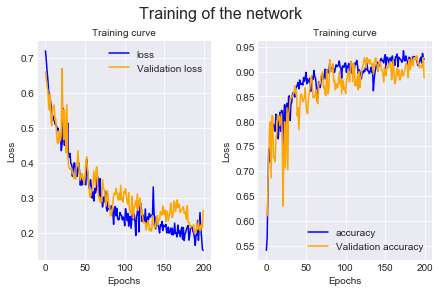

In [80]:
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(ncols=2, constrained_layout=True)
fig.suptitle("Training of the network", fontsize=16)

ax1.plot(history['loss'] , color = "blue" , label = "loss")
ax1.plot(history['val_loss'] , color = 'orange' , label = "Validation loss")
ax1.legend()
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Training curve", fontsize=10)

ax2.plot(history['acc'] , color = "blue" , label = "accuracy")
ax2.plot(history['val_acc'] , color = 'orange' , label = "Validation accuracy")
ax2.legend()
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.set_title("Training curve", fontsize=10)
fig.show()

#### Outliers detection

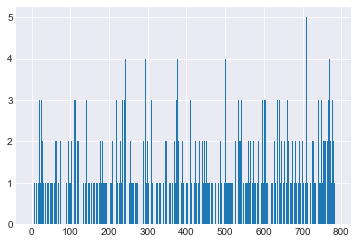

In [81]:
non_outliers = np.unique(MOM_CNN.history['hist'])
freq = plt.hist(MOM_CNN.history['hist'] , bins = np.arange(len(data_train)))[0]

(array([ 7.,  0., 15.,  0.,  0., 11.,  0.,  5.,  0.,  2.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

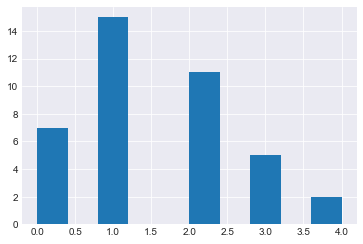

In [84]:
plt.hist(freq[-40:])

In [85]:
outliers = []

for i in range(len(data_train)):
    if i not in non_outliers:
        outliers.append(i)

In [86]:
outliers

[1,
 2,
 5,
 6,
 10,
 13,
 15,
 16,
 18,
 19,
 22,
 24,
 27,
 33,
 38,
 39,
 44,
 46,
 50,
 52,
 56,
 60,
 67,
 70,
 72,
 76,
 77,
 79,
 82,
 83,
 85,
 87,
 88,
 89,
 91,
 92,
 96,
 102,
 105,
 108,
 109,
 111,
 116,
 117,
 119,
 120,
 122,
 123,
 126,
 127,
 129,
 130,
 131,
 135,
 136,
 137,
 138,
 143,
 144,
 146,
 151,
 152,
 153,
 156,
 157,
 158,
 160,
 161,
 165,
 168,
 171,
 172,
 174,
 177,
 179,
 182,
 184,
 196,
 198,
 200,
 201,
 211,
 213,
 214,
 216,
 224,
 225,
 226,
 231,
 233,
 237,
 241,
 243,
 244,
 245,
 247,
 250,
 251,
 254,
 265,
 266,
 269,
 275,
 276,
 278,
 281,
 282,
 283,
 284,
 286,
 287,
 288,
 290,
 291,
 297,
 298,
 300,
 304,
 305,
 307,
 314,
 317,
 319,
 320,
 324,
 326,
 327,
 332,
 334,
 335,
 338,
 339,
 342,
 343,
 346,
 347,
 351,
 352,
 353,
 355,
 361,
 363,
 365,
 366,
 367,
 370,
 373,
 377,
 380,
 382,
 383,
 384,
 393,
 394,
 395,
 396,
 397,
 398,
 399,
 401,
 403,
 405,
 407,
 409,
 415,
 418,
 422,
 427,
 428,
 432,
 434,
 436,
 437,
 43

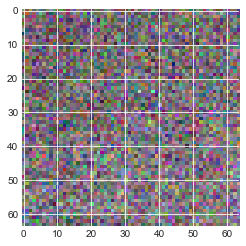

In [57]:
plt.imshow(np.swapaxes(data_train[outliers[-22]][0].detach().numpy(),0,2))

### Test on google examples

In [55]:
img_croc = Image.open("data/crocodile_example.jpg")
n,p = img_croc.size
height = min(n,p)
box = ( 0 , 0 , height , height)
img_croc = img_croc.crop(box)
n,p = img_croc.size
height = min(n,p)
box = ( 0 , 0 , height , height)
img_croc = img_croc.crop(box)
img_croc = img_croc.resize((64,64))
image_test_crocodile = np.array(np.array(img_croc)/255)

<IPython.core.display.Javascript object>


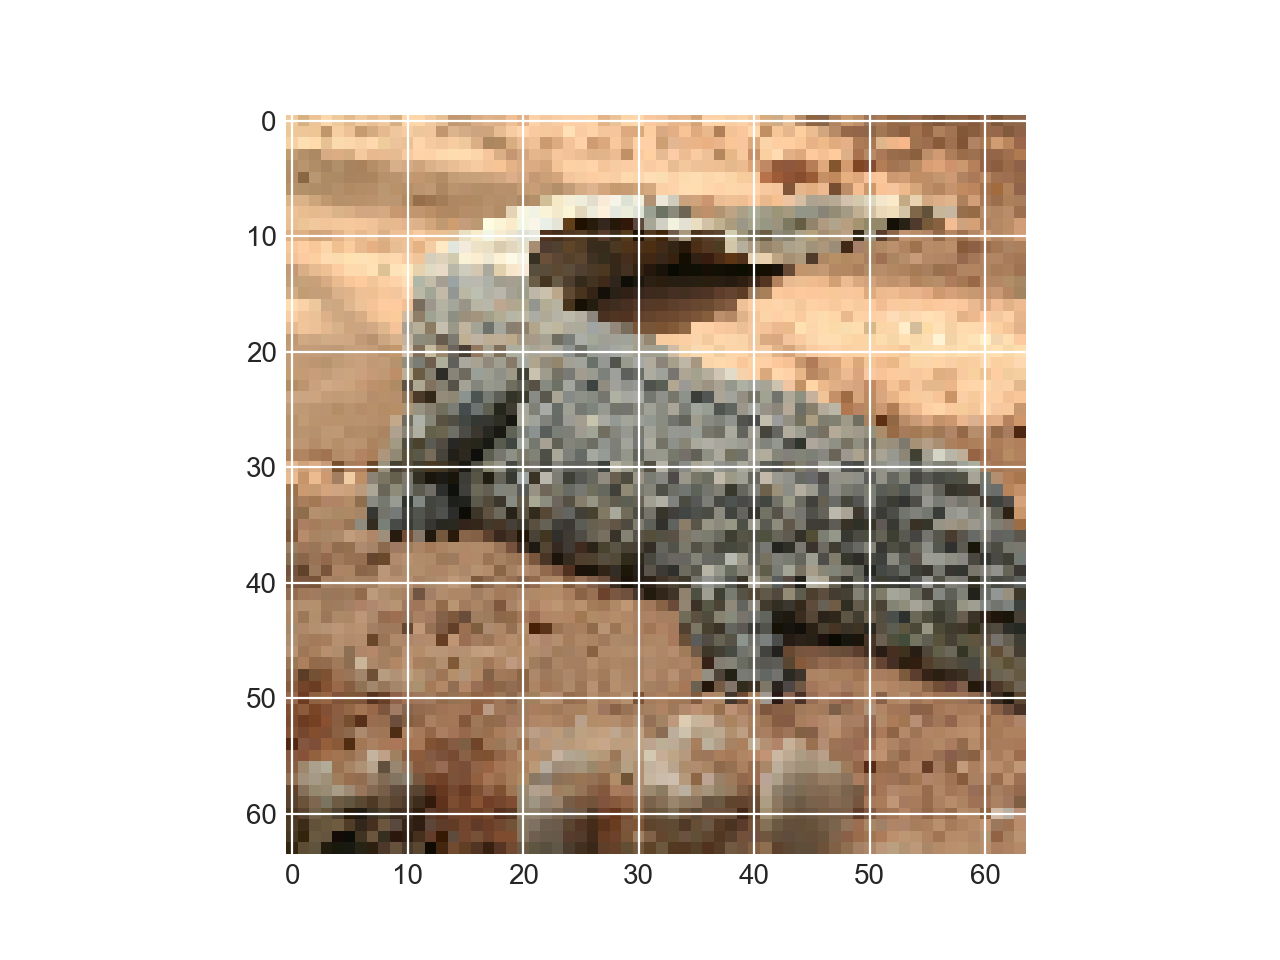

tensor([[0.3968]], grad_fn=<SigmoidBackward>)

In [60]:
plt.imshow(image_test_crocodile)
model(transformer(image_test_crocodile).unsqueeze(0).float())

In [57]:
img_ping = Image.open("data/pinguin_example.jpg")
n,p = img_ping.size
height = min(n,p)
box = ( 0 , 0 , height , height)
img_ping = img_ping.crop(box)
n,p = img_ping.size
height = min(n,p)
box = ( 0 , 0 , height , height)
img_ping = img_ping.crop(box)
img_ping = img_ping.resize((64,64))
image_test_pinguin = np.array(np.array(img_ping)/255)

<IPython.core.display.Javascript object>


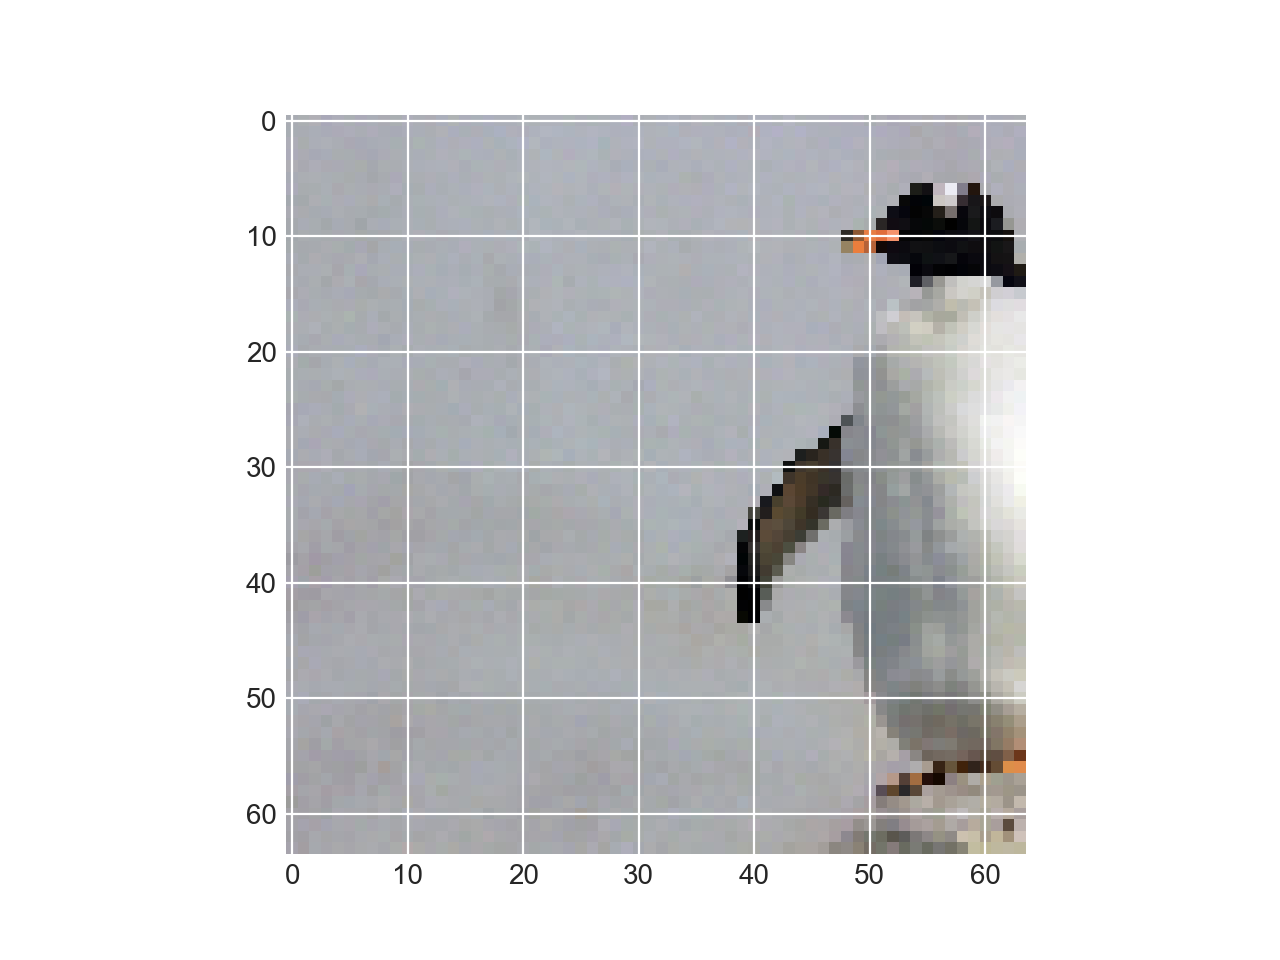

tensor([[0.5973]], grad_fn=<SigmoidBackward>)

In [58]:
plt.imshow(image_test_pinguin)
CNN_(transformer(image_test_pinguin).unsqueeze(0).float())

### Test of the robustness

Not finished

In [61]:
images = []
target = []
min_n , min_p = 1000 , 1000
i = 0

for animal in ["crocodile" , "pinguin"] : 
    
    file = os.listdir("data/tiny-imagenet-200/train/" + animal + "/images")
    
    for f in file : 
        
        img = Image.open("data/tiny-imagenet-200/train/" + animal + "/images/" + f)
        n,p = img.size
        height = min(n,p)
        box = ( 0 , 0 , height , height)
        img = img.crop(box)  # On rend l'image carré en la rognant
        #img = img.resize(( 224 , 224 ))   # On standardise la taille de l'image 
        if len(np.array(img).shape) == 3 : 
            
            images.append(np.array(img)/255)
            target.append(i)
            
    i += 1

outliers = []

file = os.listdir("data/tiny-imagenet-200/train/fish/images")
    
for f in file : 
        
    img = Image.open("data/tiny-imagenet-200/train/fish/images/" + f)
    n,p = img.size
    height = min(n,p)
    box = ( 0 , 0 , height , height)
    img = img.crop(box)
    if len(np.array(img).shape) == 3 : 
            
        outliers.append(np.array(img)/255)
        
images_train , images_test , target_train , target_test = train_test_split(images , target , random_state = random_seed)

In [64]:
data_test = indexed_dataset.Dataset(images_test , torch.FloatTensor(target_test) , transform = transformer)

accuracy_MOM = []

bar = progressbar.progressbar

for n_outliers in bar(range(1, 101, 10)):
    
    images_train_prime = images_train + outliers[:n_outliers]
    target_train_prime = target_train + [randint(0,1) for i in range(n_outliers)]
    data_train = indexed_dataset.Dataset(images_train_prime , torch.FloatTensor(target_train_prime) , transform = transformer)

    model_MOM = CNN()
    optimizer_MOM = torch.optim.Adam( model_MOM.parameters())
    loss_MOM = torch.nn.BCELoss()
    MOM_CNN = MOM_training.mom_net(model_MOM, optimizer_MOM,
                                   loss_MOM, random_seed = random_seed,
                                   batch_size = 16, n_epochs = 400)
    
    MOM_CNN.fit(data_train , data_test)

    
    accuracy_MOM.append(MOM_CNN.history['val_acc'][-1])

N/A% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([249])) that is different to the input size (torch.Size([249, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch n°0 ( 4.0 sec) : loss = 0.7036076188087463 ,validation loss =  0.7292233109474182 , accuracy : 0.4812834224598931 , validation accuracy : 0.5622489959839357
Epoch n°1 ( 4.0 sec) : loss = 0.8269685506820679 ,validation loss =  0.6936488747596741 , accuracy : 0.4812834224598931 , validation accuracy : 0.5622489959839357
Epoch n°2 ( 4.0 sec) : loss = 0.7413666248321533 ,validation loss =  0.6395281553268433 , accuracy : 0.518716577540107 , validation accuracy : 0.5783132530120482
Epoch n°3 ( 4.0 sec) : loss = 0.6621044874191284 ,validation loss =  0.6151427030563354 , accuracy : 0.6951871657754011 , validation accuracy : 0.6987951807228916
Epoch n°4 ( 4.0 sec) : loss = 0.6052378416061401 ,validation loss =  0.6147421002388 , accuracy : 0.7660427807486632 , validation accuracy : 0.7188755020080322
Epoch n°5 ( 4.0 sec) : loss = 0.5828487873077393 ,validation loss =  0.6271840333938599 , accuracy : 0.7419786096256684 , validation accuracy : 0.6626506024096386
Epoch n°6 ( 4.0 sec) : los

 10% (1 of 10) |##                       | Elapsed Time: 0:27:29 ETA:   4:07:28

Epoch n°399 ( 4.0 sec) : loss = 0.030431130900979042 ,validation loss =  0.27341437339782715 , accuracy : 0.9786096256684492 , validation accuracy : 0.9076305220883534
Training finished
Epoch n°0 ( 4.0 sec) : loss = 0.6876250505447388 ,validation loss =  0.6578161120414734 , accuracy : 0.6279683377308707 , validation accuracy : 0.6184738955823292
Epoch n°1 ( 4.0 sec) : loss = 0.6570785045623779 ,validation loss =  0.684715747833252 , accuracy : 0.6306068601583114 , validation accuracy : 0.5381526104417671
Epoch n°2 ( 4.0 sec) : loss = 0.6240990161895752 ,validation loss =  0.7536524534225464 , accuracy : 0.5646437994722955 , validation accuracy : 0.47791164658634533
Epoch n°3 ( 4.0 sec) : loss = 0.6771438121795654 ,validation loss =  0.732405960559845 , accuracy : 0.5883905013192612 , validation accuracy : 0.5100401606425703
Epoch n°4 ( 4.0 sec) : loss = 0.6574957966804504 ,validation loss =  0.6653518080711365 , accuracy : 0.6596306068601583 , validation accuracy : 0.5622489959839357


 20% (2 of 10) |#####                    | Elapsed Time: 0:57:11 ETA:   3:57:35

Epoch n°399 ( 4.0 sec) : loss = 0.05725651979446411 ,validation loss =  0.3040425181388855 , accuracy : 0.9762532981530343 , validation accuracy : 0.9116465863453815
Training finished
Epoch n°0 ( 4.0 sec) : loss = 0.7031028270721436 ,validation loss =  0.9208182096481323 , accuracy : 0.51953125 , validation accuracy : 0.43775100401606426
Epoch n°1 ( 4.0 sec) : loss = 0.8046098351478577 ,validation loss =  0.8584571480751038 , accuracy : 0.5234375 , validation accuracy : 0.4457831325301205
Epoch n°2 ( 4.0 sec) : loss = 0.7422893047332764 ,validation loss =  0.7475257515907288 , accuracy : 0.5546875 , validation accuracy : 0.4738955823293173
Epoch n°3 ( 4.0 sec) : loss = 0.6811886429786682 ,validation loss =  0.6487208604812622 , accuracy : 0.70703125 , validation accuracy : 0.642570281124498
Epoch n°4 ( 4.0 sec) : loss = 0.5964527130126953 ,validation loss =  0.6183950901031494 , accuracy : 0.7200520833333333 , validation accuracy : 0.678714859437751
Epoch n°5 ( 4.0 sec) : loss = 0.5936

 30% (3 of 10) |#######                  | Elapsed Time: 2:02:28 ETA:   7:36:56

Epoch n°399 ( 4.0 sec) : loss = 0.054093919694423676 ,validation loss =  0.17304794490337372 , accuracy : 0.9791666666666666 , validation accuracy : 0.9397590361445783
Training finished
Epoch n°0 ( 4.0 sec) : loss = 0.6879202723503113 ,validation loss =  0.6447858214378357 , accuracy : 0.5694087403598972 , validation accuracy : 0.6385542168674698
Epoch n°1 ( 4.0 sec) : loss = 0.6797307133674622 ,validation loss =  0.6413742303848267 , accuracy : 0.6670951156812339 , validation accuracy : 0.6305220883534137
Epoch n°2 ( 4.0 sec) : loss = 0.6326870918273926 ,validation loss =  0.6510987877845764 , accuracy : 0.6658097686375322 , validation accuracy : 0.606425702811245
Epoch n°3 ( 4.0 sec) : loss = 0.6196535229682922 ,validation loss =  0.6662000417709351 , accuracy : 0.6439588688946015 , validation accuracy : 0.5983935742971888
Epoch n°4 ( 4.0 sec) : loss = 0.6298761963844299 ,validation loss =  0.6807444095611572 , accuracy : 0.6388174807197944 , validation accuracy : 0.5943775100401607


 40% (4 of 10) |##########               | Elapsed Time: 2:32:16 ETA:   2:58:45

Epoch n°399 ( 4.0 sec) : loss = 0.10121972113847733 ,validation loss =  0.309394508600235 , accuracy : 0.9640102827763496 , validation accuracy : 0.8995983935742972
Training finished
Epoch n°0 ( 4.0 sec) : loss = 0.7067169547080994 ,validation loss =  0.642752468585968 , accuracy : 0.5317258883248731 , validation accuracy : 0.606425702811245
Epoch n°1 ( 4.0 sec) : loss = 0.694886326789856 ,validation loss =  0.6191966533660889 , accuracy : 0.6395939086294415 , validation accuracy : 0.6506024096385542
Epoch n°2 ( 4.0 sec) : loss = 0.6369684934616089 ,validation loss =  0.6230816841125488 , accuracy : 0.7055837563451777 , validation accuracy : 0.6867469879518072
Epoch n°3 ( 4.0 sec) : loss = 0.5998073816299438 ,validation loss =  0.6764837503433228 , accuracy : 0.633248730964467 , validation accuracy : 0.5903614457831325
Epoch n°4 ( 4.0 sec) : loss = 0.6209049820899963 ,validation loss =  0.7273557782173157 , accuracy : 0.5951776649746192 , validation accuracy : 0.5381526104417671
Epoch 

 50% (5 of 10) |############             | Elapsed Time: 3:01:54 ETA:   2:28:13

Epoch n°399 ( 4.0 sec) : loss = 0.05256247892975807 ,validation loss =  0.2262706458568573 , accuracy : 0.9733502538071066 , validation accuracy : 0.9156626506024097
Training finished
Epoch n°0 ( 4.0 sec) : loss = 0.7092174291610718 ,validation loss =  0.6771216988563538 , accuracy : 0.5877192982456141 , validation accuracy : 0.5582329317269077
Epoch n°1 ( 4.0 sec) : loss = 0.6734886169433594 ,validation loss =  0.6732469201087952 , accuracy : 0.6453634085213033 , validation accuracy : 0.5903614457831325


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


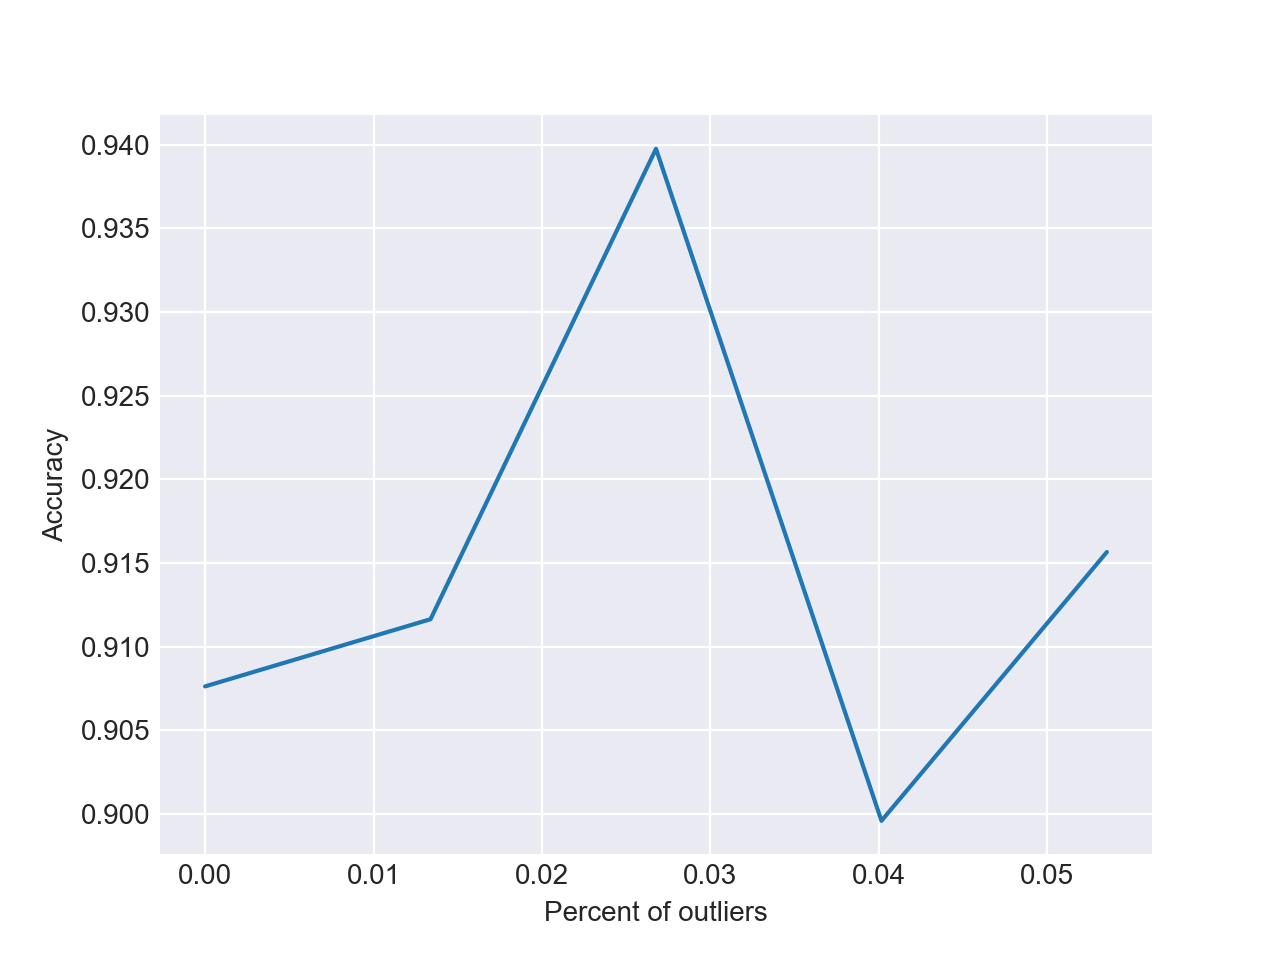

Text(0, 0.5, 'Accuracy')

In [69]:
plt.plot([0/len(target_train),10/len(target_train),20/len(target_train),30/len(target_train),40/len(target_train)],accuracy_MOM)
plt.xlabel("Percent of outliers")
plt.ylabel("Accuracy")